sign-language-mnist : https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data?select=asl_alphabet_train

chatbot dataset :  https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
# code to connect to google drive

#from google.colab import drive
#drive.mount('/content/drive')


## Read the data

In [10]:
# Define the directory containing your data
data_dir = '..\\dataset\\asl_alphabet_train'

# Initialize a list to store the data
data = []

# Loop through each folder and file in the directory
for label in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, label)):  # Check if it's a directory
        for image in os.listdir(os.path.join(data_dir, label)):
            image_path = os.path.join(data_dir, label, image)
            data.append([image_path, label])

# Create a DataFrame
asl_train_df = pd.DataFrame(data, columns=['image_path', 'label'])

# Show the first few rows of the DataFrame
asl_train_df.head()


,image_path,label
0,..\dataset\asl_alphabet_train\A\A1.jpg,A
1,..\dataset\asl_alphabet_train\A\A10.jpg,A
2,..\dataset\asl_alphabet_train\A\A100.jpg,A
3,..\dataset\asl_alphabet_train\A\A1000.jpg,A
4,..\dataset\asl_alphabet_train\A\A1001.jpg,A


In [11]:
asl_train_df.shape

(87000, 2)

In [12]:
asl_train_df['label'].value_counts()

label
A          3000
nothing    3000
Y          3000
X          3000
W          3000
V          3000
U          3000
T          3000
space      3000
S          3000
R          3000
Q          3000
P          3000
O          3000
N          3000
B          3000
M          3000
L          3000
K          3000
J          3000
I          3000
H          3000
G          3000
F          3000
E          3000
del        3000
D          3000
C          3000
Z          3000
Name: count, dtype: int64

# Quick EDA

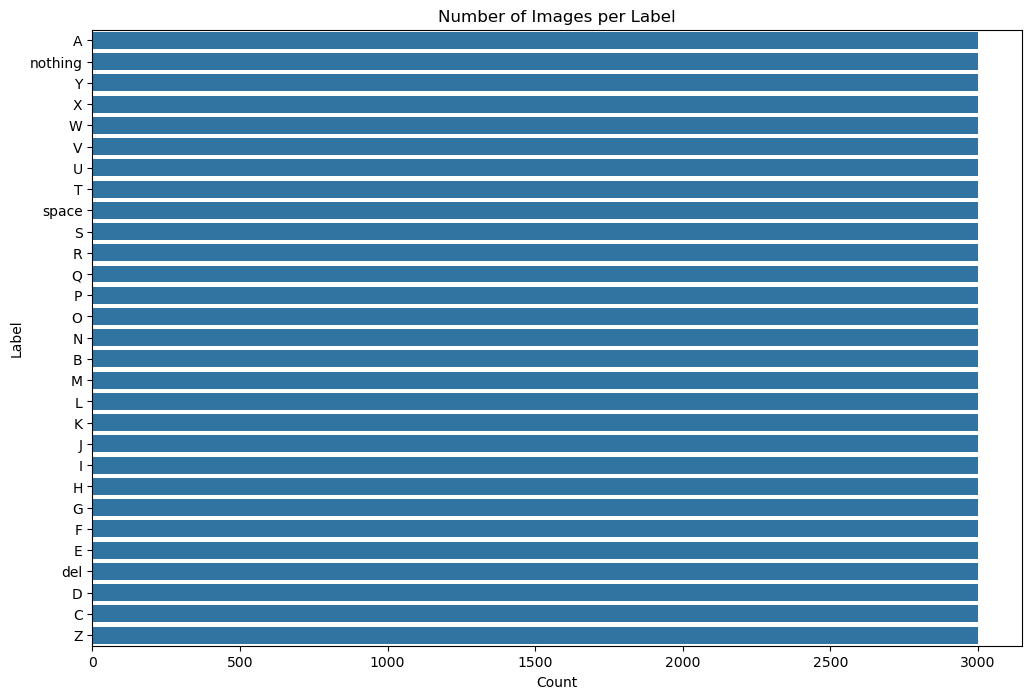

In [13]:
import seaborn as sns
# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size
sns.countplot(y='label', data=asl_train_df, order = asl_train_df['label'].value_counts().index)  # Create a countplot
plt.title('Number of Images per Label')  # Set title
plt.xlabel('Count')  # Set x-axis label
plt.ylabel('Label')  # Set y-axis label
plt.show()  # Show the plot

### Feature Extraction ( Using Mean Pixel Intensity & Standard Deviation)

In [14]:
from PIL import Image
import numpy as np
import pandas as pd

# Define a function to extract mean intensity from an image
def extract_mean_intensity(image_path):
    image = Image.open(image_path)
    image = image.convert('L')  # Convert to grayscale
    array = np.array(image)
    return np.mean(array)

# Define a function to extract standard deviation of intensity from an image
def extract_std_deviation(image_path):
    image = Image.open(image_path)
    image = image.convert('L')  # Convert to grayscale
    array = np.array(image)
    return np.std(array)


# Apply feature extraction to each image in the DataFrame
asl_train_df['mean_intensity'] = asl_train_df['image_path'].apply(extract_mean_intensity)
asl_train_df['std_deviation'] = asl_train_df['image_path'].apply(extract_std_deviation)


## Correlation Matrix plot between Brightness and Contrast

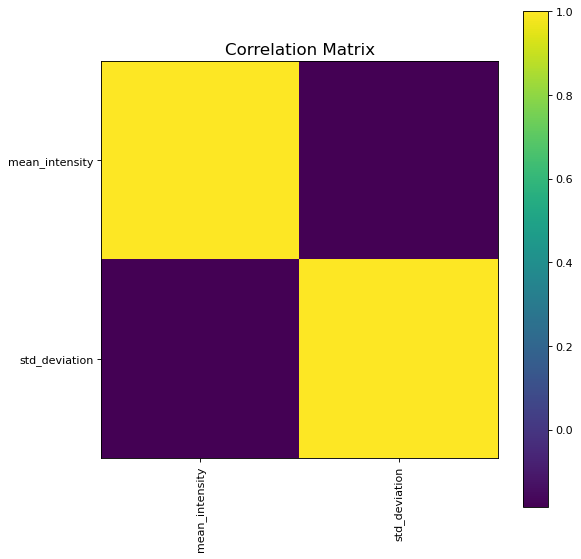

In [15]:
import matplotlib.pyplot as plt

def plotCorrelationMatrix(df, graphWidth):
    df_numeric = df.select_dtypes(include=[np.number])  # Select only numeric columns
    if df_numeric.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df_numeric.shape[1]}) is less than 2')
        return
    corr = df_numeric.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

# Plot the correlation matrix
plotCorrelationMatrix(asl_train_df, graphWidth=8)


In image processing and analysis, feature extraction such as mean pixel intensity and standard deviation is crucial for distilling complex image data into more interpretable, numerical forms. 

Mean pixel intensity provides a measure of the overall brightness or luminance of an image, which can be critical for tasks that involve brightness normalization or thresholding. 

Standard deviation, on the other hand, measures the variability or contrast within the pixel values, offering insights into the texture and detail present in the image. 

The correlation matrix plot, showing a negative correlation between these two features, suggests that images with higher average brightness tend to have less contrast and variability in their pixel values. Understanding this relationship helps in optimizing image processing tasks and improving algorithms for tasks like image classification, where consistent image quality can influence performance.


## Scatter and Density Plot

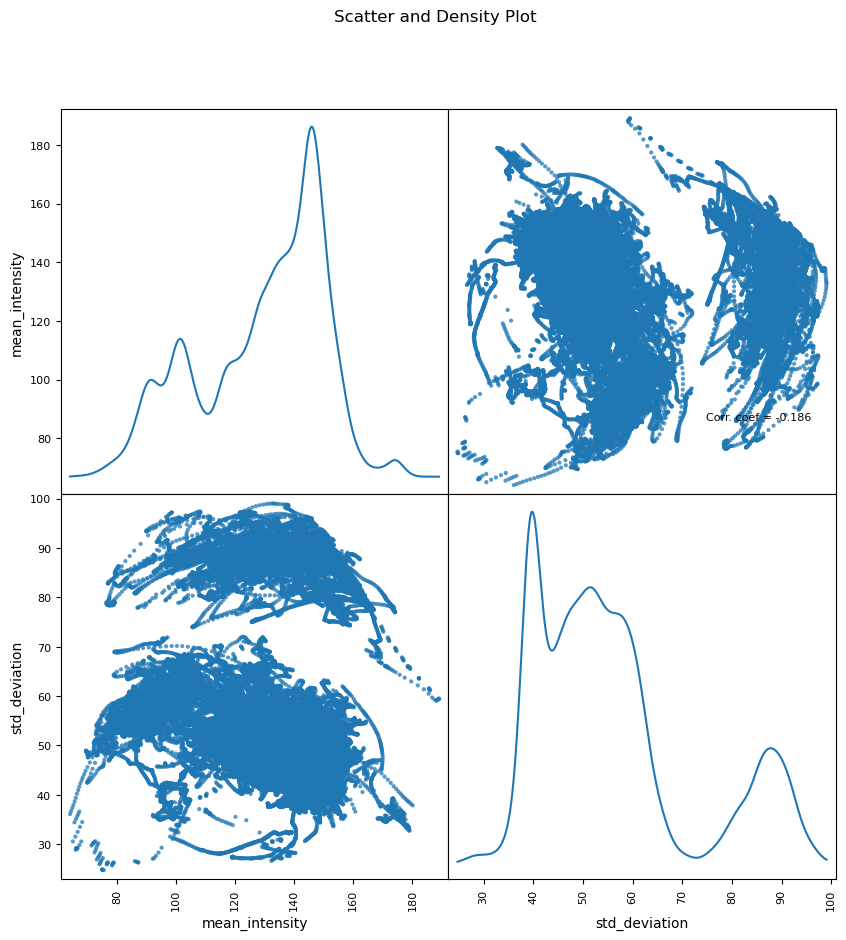

In [16]:
import matplotlib.pyplot as plt

def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # Keep only numerical columns
    df = df.dropna(axis=1)  # Drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns with more than 1 unique value
    columnNames = list(df)
    if len(columnNames) > 10:  # Limit the number of columns to prevent overcrowding
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate(f'Corr. coef = {corrs[i, j]:.3f}', (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# Call the function to plot
plotScatterMatrix(asl_train_df, plotSize=10, textSize=8)


The scatter and density plot generated from ASL alphabet image dataset provides crucial insights into the relationships between mean intensity and standard deviation of pixel values. 

The density plots indicate predominant brightness levels and variability in image contrast, which are important for understanding image characteristics. 

The scatter plot reveals a slight positive correlation between mean intensity and standard deviation, suggesting these features are somewhat related but still provide independent information. 

This visualization is essential for guiding feature selection and engineering in machine learning models aimed at classifying ASL signs. Overall, it helps ensure that models are trained on informative, non-redundant features, potentially enhancing classification accuracy.

### Creating Training & Validation Dataset

In [17]:
asl_train_df.head()

,image_path,label,mean_intensity,std_deviation
0,..\dataset\asl_alphabet_train\A\A1.jpg,A,113.822725,56.604702
1,..\dataset\asl_alphabet_train\A\A10.jpg,A,113.820850,56.350592
2,..\dataset\asl_alphabet_train\A\A100.jpg,A,105.395600,58.857844
3,..\dataset\asl_alphabet_train\A\A1000.jpg,A,141.781600,43.187863
4,..\dataset\asl_alphabet_train\A\A1001.jpg,A,141.954150,60.112078


In [18]:
new_asl_df = asl_train_df.drop(['mean_intensity', 'std_deviation'], axis =1)
new_asl_df.head()

,image_path,label
0,..\dataset\asl_alphabet_train\A\A1.jpg,A
1,..\dataset\asl_alphabet_train\A\A10.jpg,A
2,..\dataset\asl_alphabet_train\A\A100.jpg,A
3,..\dataset\asl_alphabet_train\A\A1000.jpg,A
4,..\dataset\asl_alphabet_train\A\A1001.jpg,A


In [19]:
from sklearn.model_selection import train_test_split

# split the dataframe into training and validation sets
asl_train, asl_val = train_test_split(new_asl_df, test_size=0.1, shuffle=True, random_state=42)

# Print the shapes of the training and validation sets
print("Training set shape:", asl_train.shape)
print("Validation set shape:", asl_val.shape)

Training set shape: (78300, 2)
Validation set shape: (8700, 2)


## Data Augmentation

In [20]:
%%time  

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator for data augmentation

# Define batch size and image size
batch_size = 32
image_size = (64, 64)

# Initialize the ImageDataGenerator for training with data augmentation parameters
train_generator = ImageDataGenerator(rescale=1./255,  # Rescale pixel values to [0, 1]
                                    rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                    height_shift_range=0.1,  # Randomly shift images vertically by up to 10%
                                    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
                                    shear_range=0.1,  # Apply shear transformations
                                    zoom_range=0.1,  # Randomly zoom in on images by up to 10%
                                    horizontal_flip=True,  # Randomly flip images horizontally
                                    fill_mode='nearest')  # Fill in new pixels with the nearest pixel values

# Initialize the ImageDataGenerator for validation without data augmentation
val_generator = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

# Create the training image generator from the dataframe
train_images = train_generator.flow_from_dataframe(asl_train, x_col='image_path', y_col='label',
                                                   color_mode='grayscale', class_mode='categorical',
                                                   batch_size=batch_size, target_size=image_size,
                                                   shuffle=True, seed=0)  

# Create the validation image generator from the dataframe
val_images = val_generator.flow_from_dataframe(asl_val, x_col='image_path', y_col='label',
                                               color_mode='grayscale', class_mode='categorical',
                                               batch_size=batch_size, target_size=image_size)  

Found 78300 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
CPU times: total: 188 ms
Wall time: 4.71 s


## Model Architecture

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Determine the output shape based on the number of unique labels in the training data
output_shape = len(set(train_images.labels))

# Define the model architecture
model = Sequential([
    Input(shape=image_size + (1,), name='input_layer'),  # Input layer with the shape of the images

    Conv2D(16, (3, 3), activation='relu'),  # First convolutional layer with 16 filters
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer with pool size of 2x2

    Conv2D(32, (3, 3), activation='relu'),  # Second convolutional layer with 32 filters
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer with pool size of 2x2

    Conv2D(64, (3, 3), activation='relu'),  # Third convolutional layer with 64 filters
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer with pool size of 2x2

    Conv2D(128, (3, 3), activation='relu'),  # Fourth convolutional layer with 128 filters
    
    GlobalAveragePooling2D(),  # Global average pooling layer
    BatchNormalization(),  # Batch normalization layer

    Dense(512, activation='relu'),  # First dense layer with 512 units
    Dropout(0.5),  # Dropout layer with 50% dropout rate

    Dense(256, activation='relu'),  # Second dense layer with 256 units
    Dropout(0.5),  # Dropout layer with 50% dropout rate

    Dense(128, activation='relu'),  # Third dense layer with 128 units

    Dense(output_shape, activation='softmax', name='output_layer')  # Output layer with softmax activation
])

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=CategoricalCrossentropy(), 
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

## Model Training

In [22]:
from tensorflow.keras.models import load_model

# load the model
#model = load_model("asl_model.h5")

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor the validation loss
                              factor=0.2,  # Factor by which the learning rate will be reduced
                              patience=10,  # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=1e-6)  # Lower bound on the learning rate

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('best_model_2.h5',  # File path to save the model
                                    monitor='val_accuracy',  # Monitor validation accuracy
                                    save_best_only=True,  # Save only the best model
                                    mode='max',  # Save the model with the maximum accuracy
                                    verbose=1)  # Print messages when saving

# Train the model
history = model.fit(
    train_images,  # Training data
    epochs=50,  # Number of epochs to train
    validation_data=val_images,  # Validation data
    callbacks=[reduce_lr, model_checkpoint]  # List of callbacks to be called during training
)

# Print the training history
print(history.history)


Epoch 1/50
2446/2447 [============================>.] - ETA: 0s - loss: 2.0617 - accuracy: 0.3575
Epoch 1: val_accuracy improved from -inf to 0.62655, saving model to best_model_2.h5
2447/2447 [==============================] - 60s 24ms/step - loss: 2.0613 - accuracy: 0.3576 - val_loss: 1.0542 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 2/50
2446/2447 [============================>.] - ETA: 0s - loss: 0.9777 - accuracy: 0.6719
Epoch 2: val_accuracy improved from 0.62655 to 0.84839, saving model to best_model_2.h5
2447/2447 [==============================] - 57s 23ms/step - loss: 0.9777 - accuracy: 0.6719 - val_loss: 0.4446 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 3/50
2445/2447 [============================>.] - ETA: 0s - loss: 0.7054 - accuracy: 0.7662
Epoch 3: val_accuracy improved from 0.84839 to 0.87747, saving model to best_model_2.h5
2447/2447 [==============================] - 58s 24ms/step - loss: 0.7052 - accuracy: 0.7663 - val_loss: 0.3390 - val_accuracy: 0.8775 - lr: 0.0010
E

### Save the trained model

In [24]:
# Save the model to the current directory
# model.save('asl_model.h5')  

## Visualize the Training and Validation Loss and Accuracy

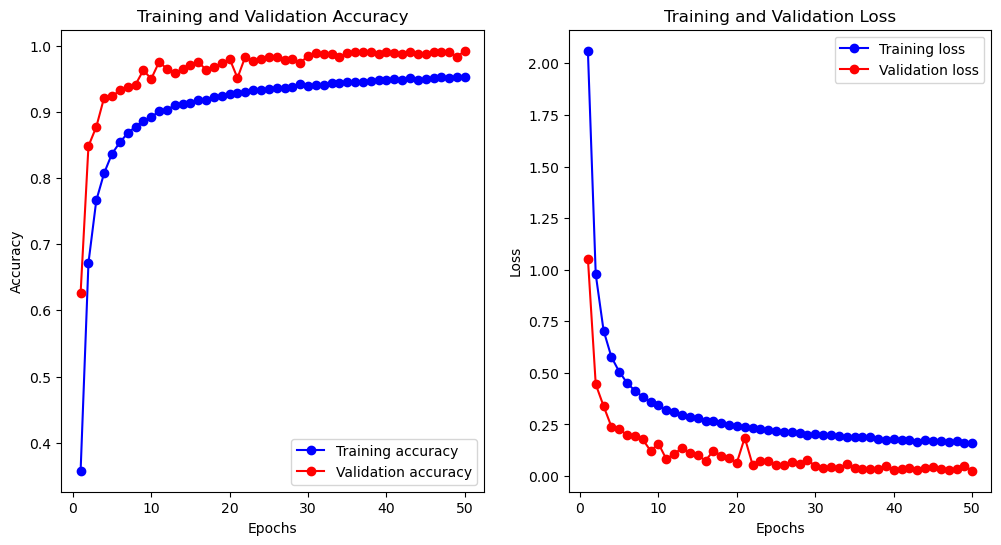

In [25]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = history.history

# Extract the metrics
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create epochs range for x-axis
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


## Model Evaluation on ASL Test dataset

In [26]:
from tensorflow.keras.models import load_model

# load the model
model = load_model("asl_model.h5")

In [27]:
# Save the dictionary to a file
import pickle
with open('history_dict.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

In [28]:
# Load the dictionary from the file
with open('history_dict.pkl', 'rb') as file:
    loaded_history_dict = pickle.load(file)

print(loaded_history_dict)

{'loss': [2.0612993240356445, 0.9776553511619568, 0.7052192091941833, 0.5767728686332703, 0.5050854086875916, 0.4513682425022125, 0.4128209054470062, 0.38478416204452515, 0.35735568404197693, 0.34323057532310486, 0.3191038966178894, 0.31109756231307983, 0.29362526535987854, 0.28838837146759033, 0.28270918130874634, 0.2647415101528168, 0.2690436542034149, 0.2560632824897766, 0.24935513734817505, 0.24345237016677856, 0.23681969940662384, 0.23177726566791534, 0.2275576889514923, 0.22315919399261475, 0.22021780908107758, 0.21389268338680267, 0.21422119438648224, 0.20781046152114868, 0.2003995180130005, 0.20495964586734772, 0.19723382592201233, 0.19952285289764404, 0.19254736602306366, 0.19055277109146118, 0.1895037740468979, 0.18788780272006989, 0.1867915391921997, 0.17760175466537476, 0.17685775458812714, 0.1778547316789627, 0.17595550417900085, 0.17344753444194794, 0.16609622538089752, 0.1761433482170105, 0.16907751560211182, 0.1687229722738266, 0.16293971240520477, 0.16799740493297577, 